In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

1)      Relative FL

2)      Breakdown by diversity, plot each # of strains together (color by # of strains)

3)      Box plots: growth rate, decline rate, FL @ 40 and 60 days – by diversity, by strain

4)      PCA 3 dimension

5)      What combinations are clustered non-randomly (e.g. PCA, tSNE)

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_style('white')
sns.set_context('poster')

In [5]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MIT0604', 'MIT9312', 'MED4', 'Natl2A', 'MIT9313']
ppallete = ['#f79934', '#face6e', '#62A586', '#7A9BC8', '#F47681', ]
# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']
#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [6]:
MIT0604_color = '#f79934'
MIT9312_color = '#face6e'
MED4_color = '#62A586'
Natl2A_color = '#7A9BC8'
MIT9313_color = '#F47681'
SYN_color = '#6cf0ba'
syn_0606_color = '#d13f75'
syn_natl_color = '#eeb7cb'
syn_natl_0604_color = '#b9d2d8'
other_color = 'lightgrey'
syn_natl_color = '#4ec4cf' #'#54a4ba' # '#6cf0e1'
syn_0606_color = '#dffc03' #'#8df06c'
natl_0604_color = '#70d156' #'#2e6e54'
syn_natl_0604_color = '#2e6e54'
SYN_color = '#6cf0ba'
ppallete = ['#f79934', '#face6e', '#62A586', '#7A9BC8', '#F47681', SYN_color]


color_dict = {
'MIT0604' : '#f79934',
'MIT9312' : '#face6e',
'MED4' : '#62A586',
'NATL2A' :  '#7A9BC8',
'MIT9313' : '#F47681',
'Syn WH8102' : '#6cf0ba',
}

In [7]:
species = ['MIT0604', 'MIT9312', 'MED4', 'NATL2A', 'MIT9313', 'Syn WH8102']

In [8]:
os.listdir('6x6')

['6x6_setup.csv', 'fl_exp1.csv', 'fl_exp2.csv', 'fl_exp3.csv']

In [9]:
setup_columns = ['Sample', 'MED4', '9313', '9312', 'NATL2A', 'MIT0604', 'Syn WH8102',
       'Total tubes', 'how many in 1 tube ?']
use_setup_columns = ['Sample', 'MED4', '9313', '9312', 'NATL2A', 'MIT0604', 'Syn WH8102']

setup_df = pd.read_csv(os.path.join('6x6', '6x6_setup.csv'), names=setup_columns, usecols=use_setup_columns)

In [10]:
setup_df.dropna(axis=0, subset=['Sample'], inplace=True)

In [11]:
for c in setup_df.columns:
    setup_df[c] = pd.to_numeric(setup_df[c], downcast='integer')

In [12]:
setup_df.rename(columns={'9313' : 'MIT9313', '9312':'MIT9312'}, inplace=True)

In [13]:
setup_df.head()

,Sample,MED4,MIT9313,MIT9312,NATL2A,MIT0604,Syn WH8102
2,1,1.0,NaN,NaN,NaN,NaN,NaN
3,2,NaN,2.0,NaN,NaN,NaN,NaN
4,3,NaN,NaN,3.0,NaN,NaN,NaN
5,4,NaN,NaN,NaN,4.0,NaN,NaN
6,5,NaN,NaN,NaN,NaN,5.0,NaN


In [14]:
exp1_df = pd.read_csv(os.path.join('6x6', 'fl_exp1.csv'))
exp2_df = pd.read_csv(os.path.join('6x6', 'fl_exp2.csv'))

In [15]:
exp1_df = pd.melt(exp1_df, id_vars=['Date', 'Day'], value_name='FL', var_name='Sample')
exp2_df = pd.melt(exp2_df, id_vars=['Date', 'Day'], value_name='FL', var_name='Sample')

In [16]:
exp1_df.head()

,Date,Day,Sample,FL
0,6/20/2019 12:19,0.000000,1A,0.172
1,6/21/2019 16:03,1.155556,1A,0.250
2,6/23/2019 13:56,3.067361,1A,0.482
3,6/24/2019 12:22,4.002083,1A,0.703
4,6/25/2019 9:00,4.861806,1A,0.781


In [17]:
exp2_df.head()

,Date,Day,Sample,FL
0,7/29/2019 14:54,0.000000,1A,0.009
1,7/31/2019 14:54,2.000000,1A,0.019
2,8/1/2019 12:28,2.898611,1A,-0.019
3,8/4/2019 16:32,6.068056,1A,0.028
4,8/6/2019 13:10,7.927778,1A,0.009


In [18]:
exp1_df['sample_prefix'] = pd.to_numeric(exp1_df.Sample.str.rstrip('[ABCDEFGH]'))
exp2_df['sample_prefix'] = pd.to_numeric(exp2_df.Sample.str.rstrip('[ABCDEFGH]'))

In [19]:
exp1_df['experiment'] = 'e1'
exp2_df['experiment'] = 'e2'

In [20]:
setup_df.index = setup_df.Sample

In [21]:
tmp_df = setup_df.drop(columns=['Sample']).notna()

In [22]:
tmp_df['num_of_species'] = tmp_df.sum(axis=1)

In [23]:
tmp_df['ssp'] = pd.melt(setup_df, id_vars=['Sample']).dropna().groupby('Sample')['variable'].unique().str.join(',')

In [24]:
exp1_df = pd.merge(exp1_df, tmp_df, how='left', left_on='sample_prefix', right_index=True)
exp2_df = pd.merge(exp2_df, tmp_df, how='left', left_on='sample_prefix', right_index=True)

In [25]:
exp1_df.loc[exp1_df['FL']< 0.05,'FL'] = 0.05
exp2_df.loc[exp2_df['FL']< 0.05,'FL'] = 0.05

In [26]:
exp1_df.loc[:,'relative FL'] = exp1_df.groupby('Sample')['FL'].apply(lambda x: x / x.max())
exp2_df.loc[:,'relative FL'] = exp2_df.groupby('Sample')['FL'].apply(lambda x: x / x.max())

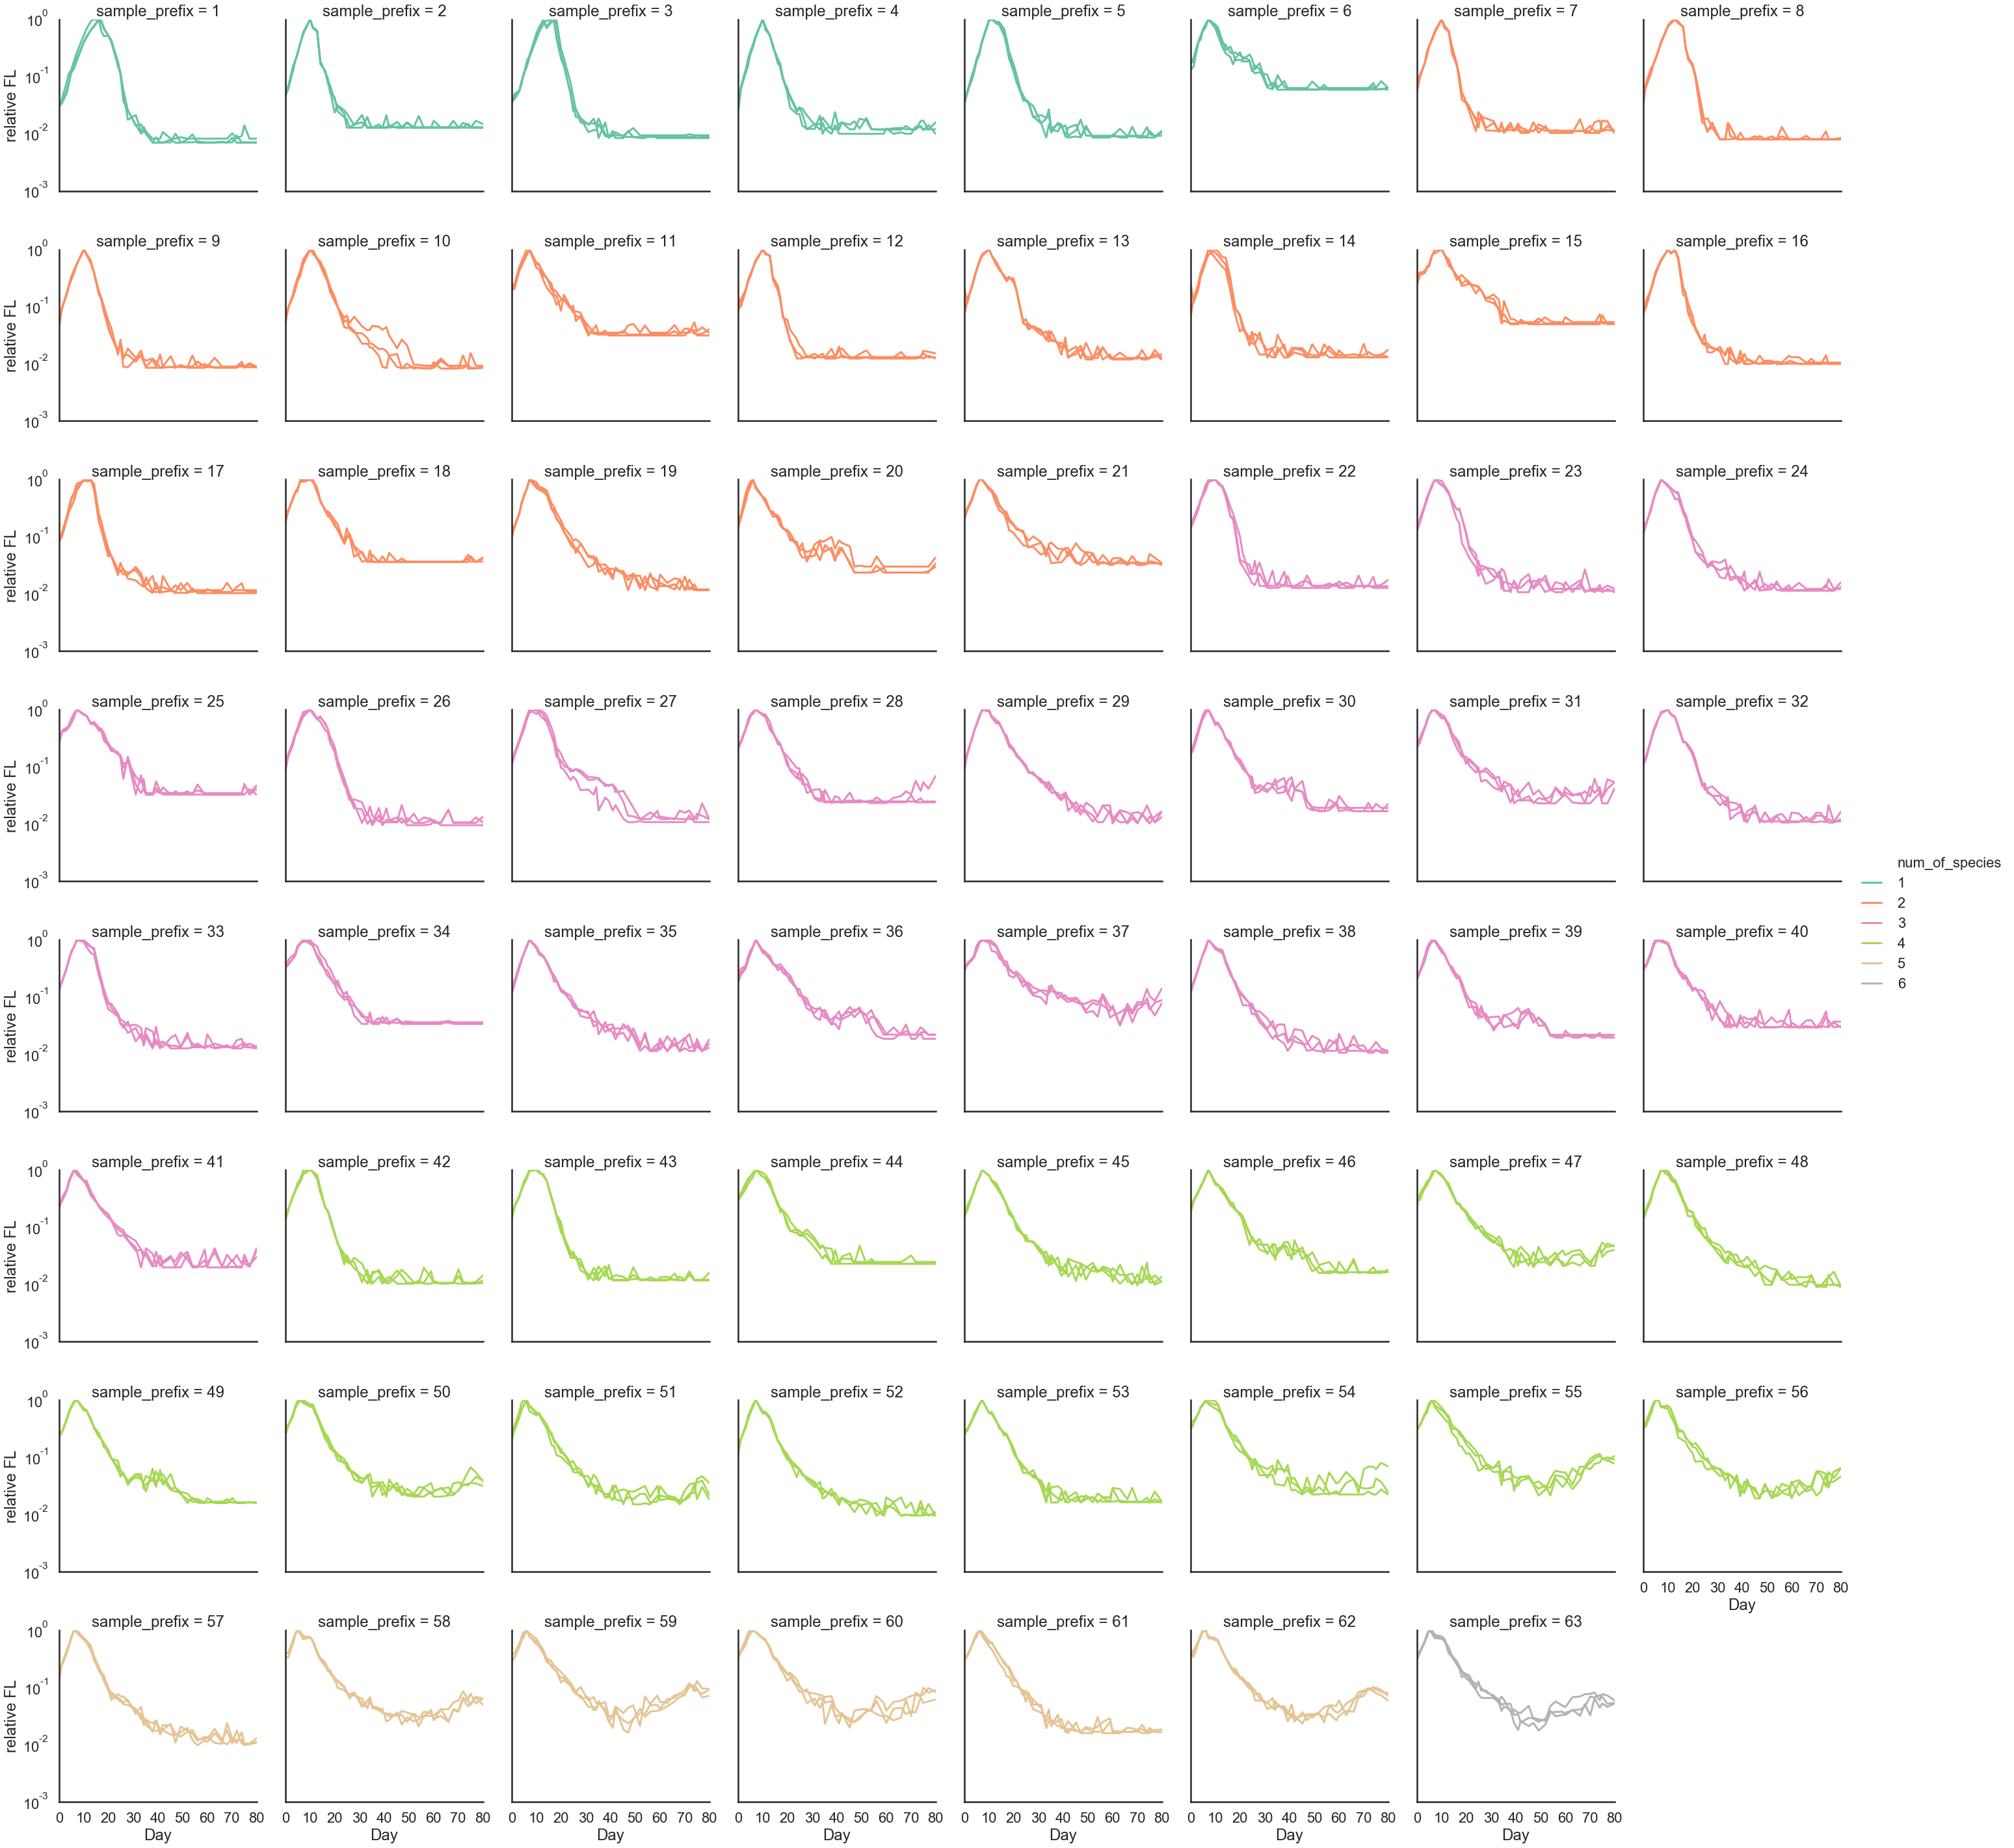

In [27]:
g = sns.relplot(data=exp1_df, x='Day', y='relative FL', col='sample_prefix', col_wrap=8, kind='line', #ci='sd',
                            estimator=None, units='Sample',

                hue='num_of_species', palette='Set2', legend='full')
g.set(yscale='log')

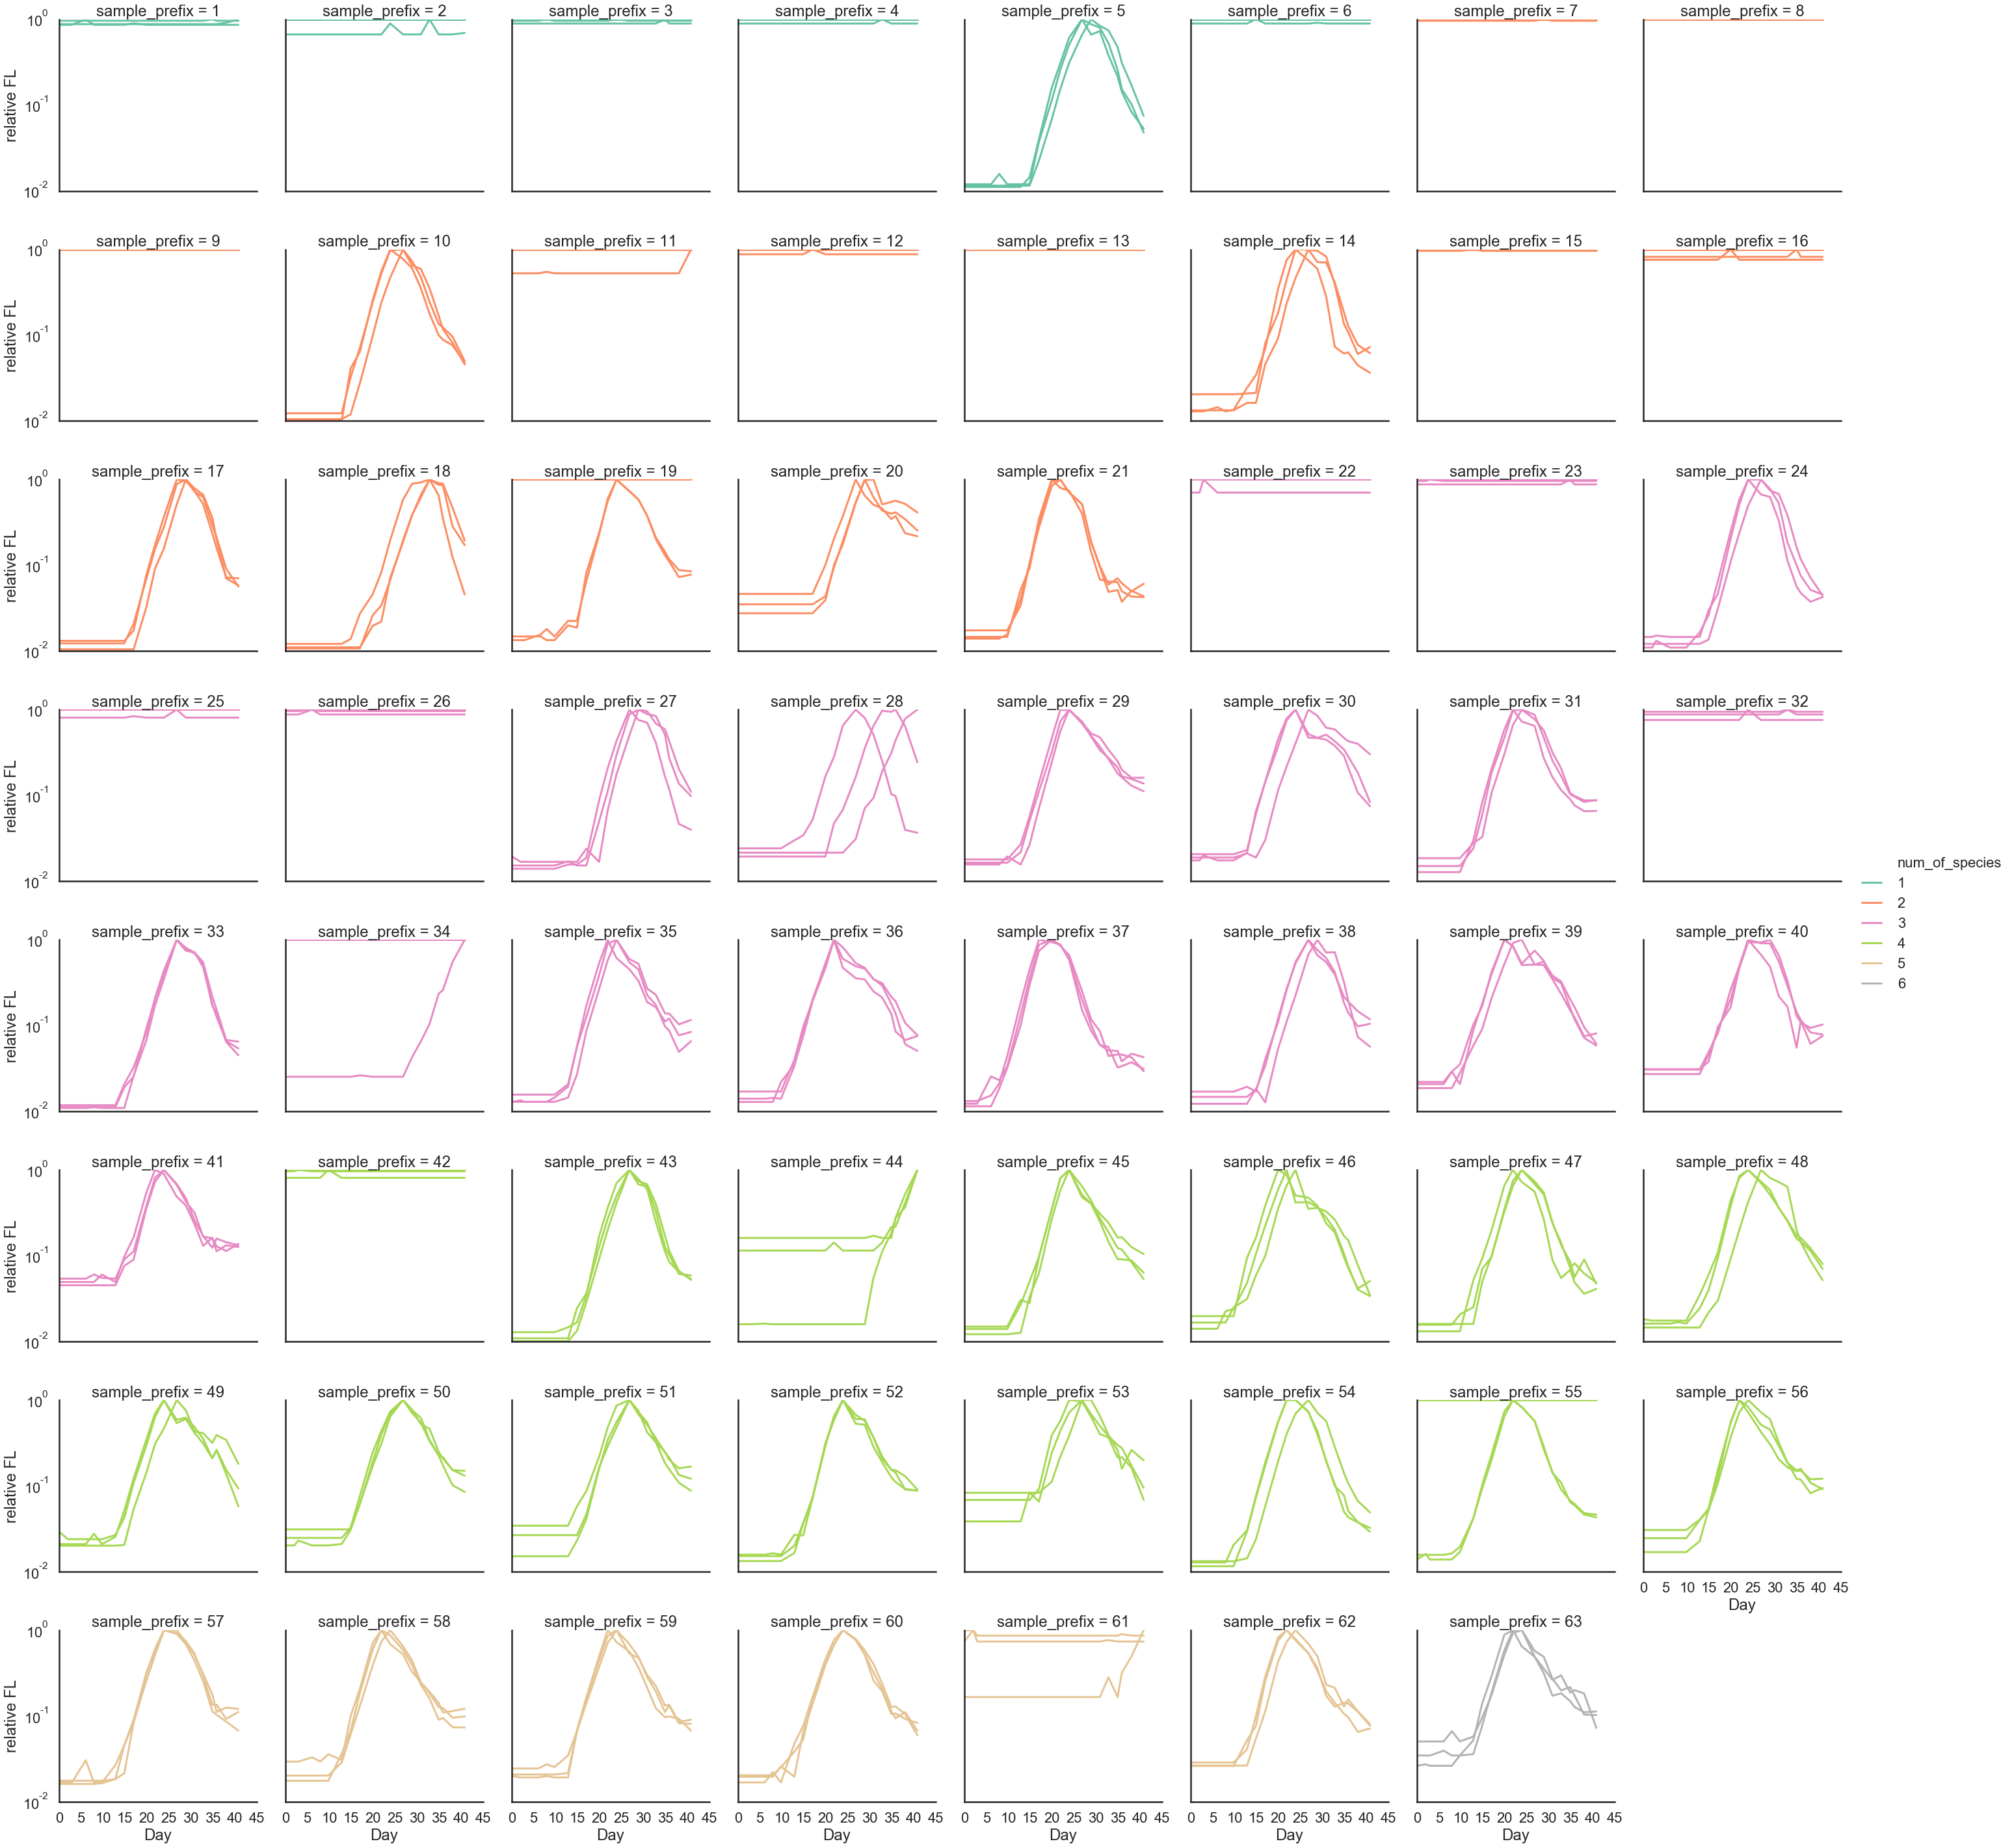

In [28]:
g = sns.relplot(data=exp2_df, x='Day', y='relative FL', col='sample_prefix', col_wrap=8, kind='line', #ci='sd', 
                            estimator=None, units='Sample',

                hue='num_of_species', palette='Set2', legend='full')
g.set(yscale='log')

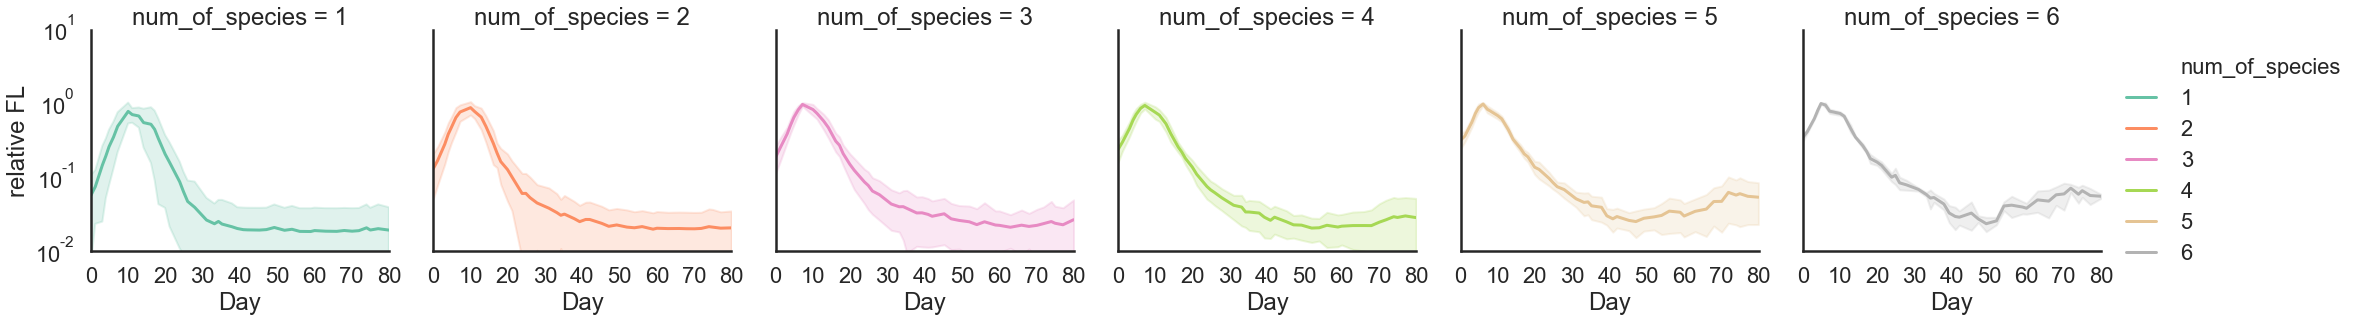

In [29]:
g = sns.relplot(data=exp1_df, x='Day', y='relative FL', col='num_of_species', kind='line', ci='sd',
                hue='num_of_species', palette='Set2', legend='full')
               
g.set(yscale='log')

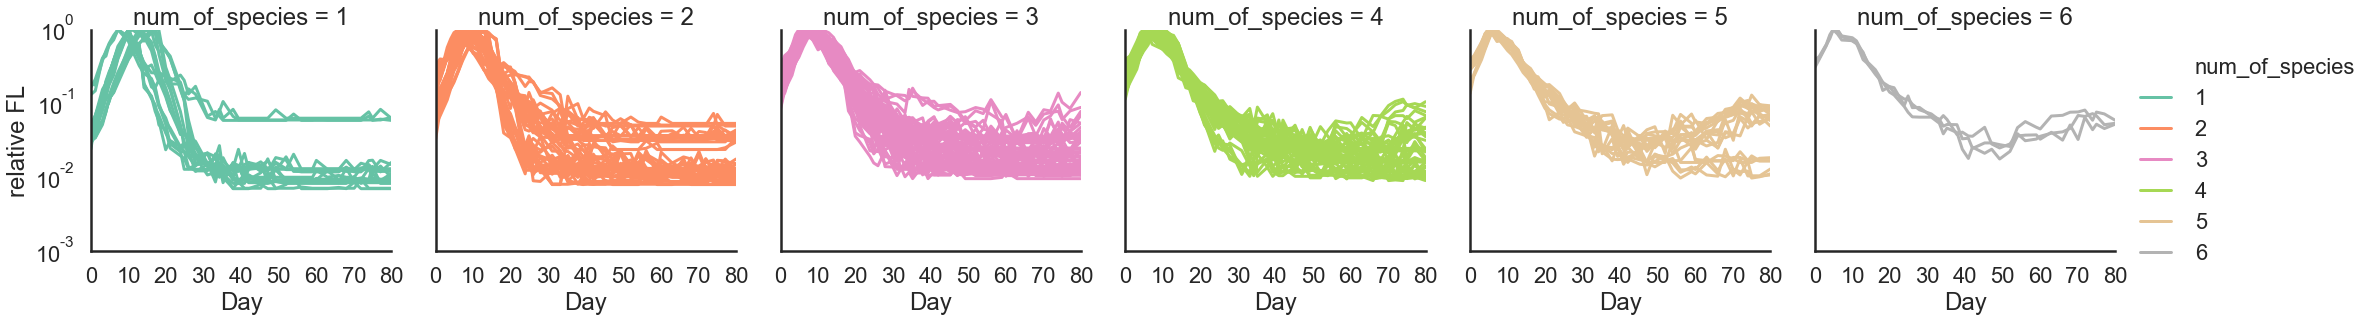

In [30]:
g = sns.relplot(data=exp1_df, x='Day', y='relative FL', col='num_of_species', kind='line', #ci='sd',
                            estimator=None, units='Sample',
                hue='num_of_species', palette='Set2', legend='full')
               
g.set(yscale='log')

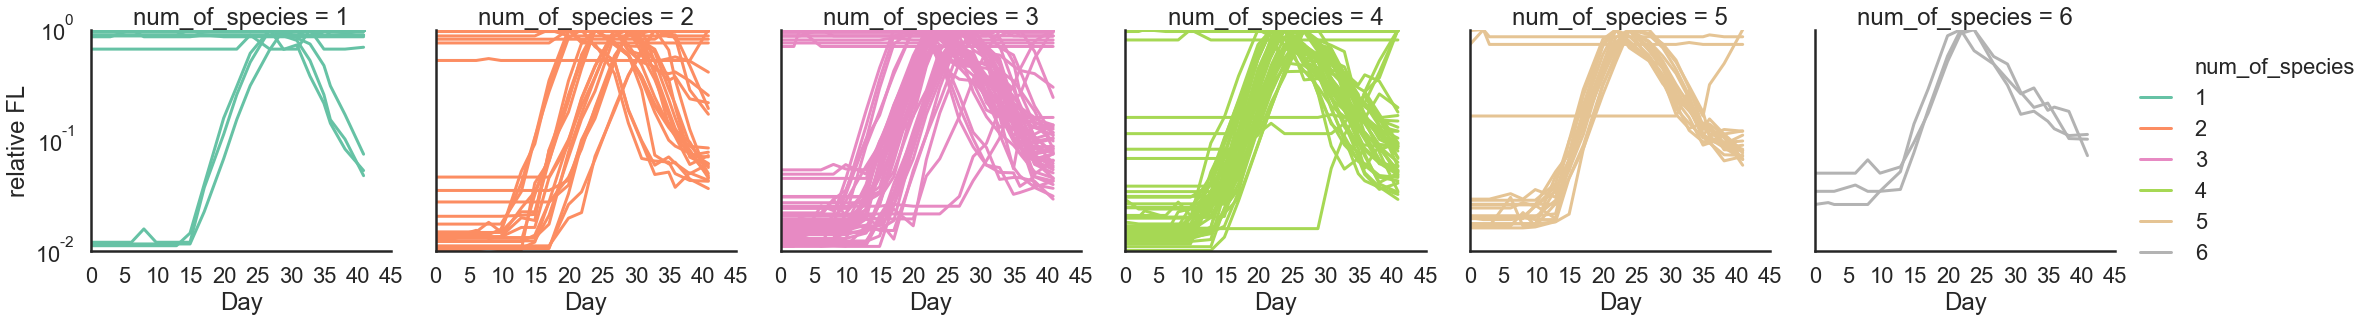

In [31]:
g = sns.relplot(data=exp2_df, x='Day', y='relative FL', col='num_of_species', kind='line', 
               # ci='sd'
            estimator=None, units='Sample',
                hue='num_of_species', palette='Set2', legend='full')
g.set(yscale='log')

In [32]:
exp1_df.columns

Index(['Date', 'Day', 'Sample', 'FL', 'sample_prefix', 'experiment', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102',
       'num_of_species', 'ssp', 'relative FL'],
      dtype='object')

In [33]:
exp1_dfm = pd.melt(exp1_df, id_vars=['Date', 'Day', 'Sample', 'relative FL', 'sample_prefix', 'experiment', 'num_of_species'],
       var_name='sp', value_vars=species)
exp2_dfm = pd.melt(exp2_df, id_vars=['Date', 'Day', 'Sample', 'relative FL', 'sample_prefix', 'experiment', 'num_of_species'],
       var_name='sp', value_vars=species)

In [34]:
exp1_dfm.sp.value_counts()

NATL2A        8505
MED4          8505
Syn WH8102    8505
MIT0604       8505
MIT9312       8505
MIT9313       8505
Name: sp, dtype: int64

In [35]:
exp1_dfm['value'].value_counts()

True     25920
False    25110
Name: value, dtype: int64

In [36]:
exp1_dfm = exp1_dfm.loc[exp1_dfm['value']]
exp2_dfm = exp2_dfm.loc[exp2_dfm['value']]
exp1_dfm.drop(columns=['value'], inplace=True)
exp2_dfm.drop(columns=['value'], inplace=True)

In [37]:
exp1_dfm.sp.value_counts()

NATL2A        4320
MED4          4320
MIT0604       4320
Syn WH8102    4320
MIT9312       4320
MIT9313       4320
Name: sp, dtype: int64

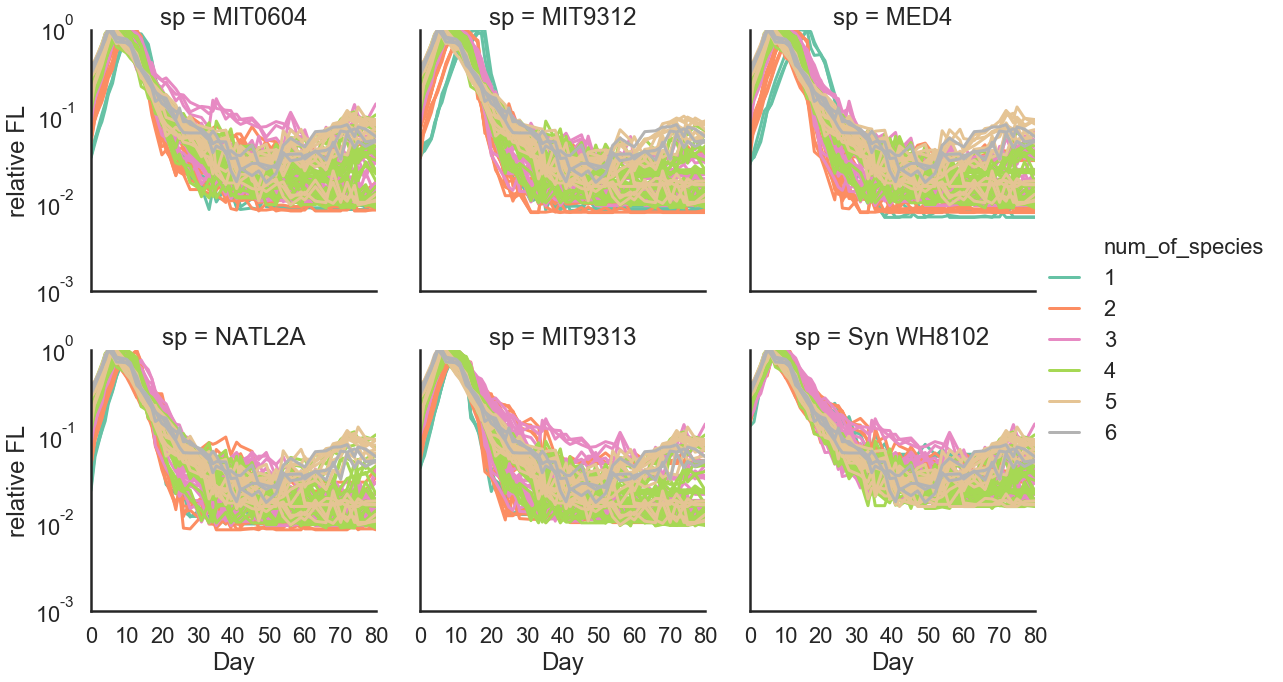

In [38]:
g = sns.relplot(data=exp1_dfm, x='Day', y='relative FL', kind='line', #ci='sd',
            estimator=None, units='Sample',
            col='sp', col_wrap=3, #aspect=2,
                hue='num_of_species', palette='Set2', legend='full'
               )
g.set(yscale='log')

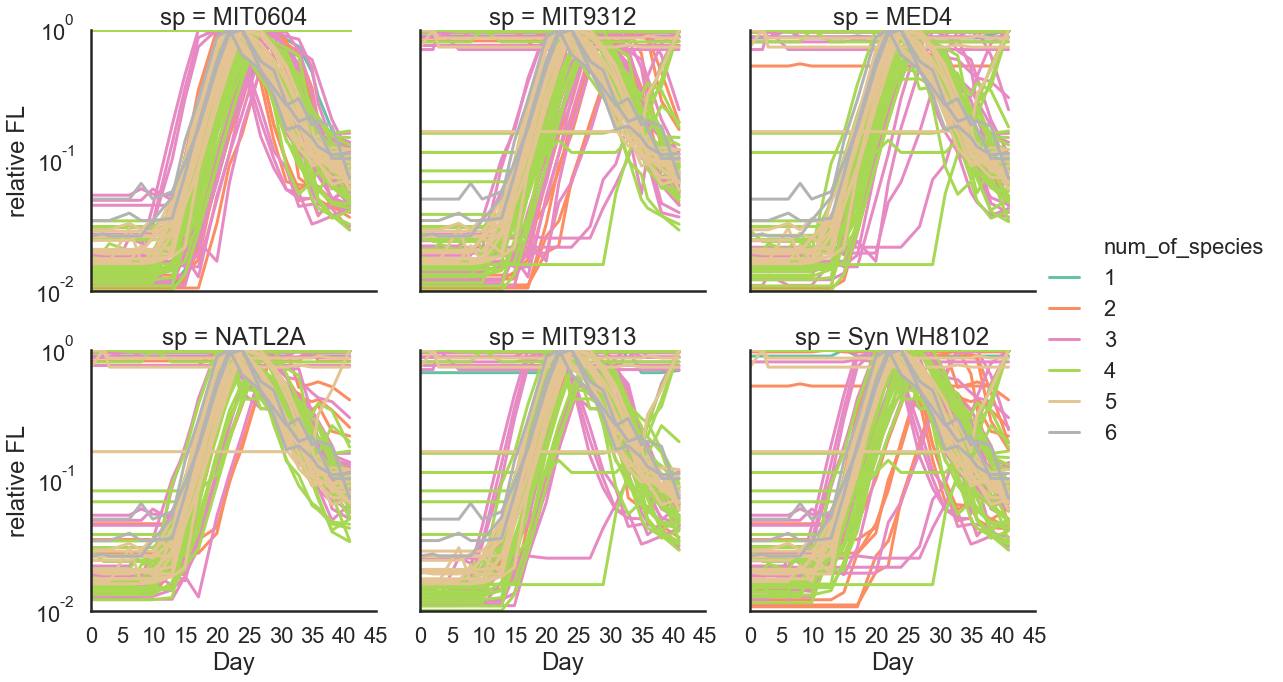

In [39]:
g = sns.relplot(data=exp2_dfm, x='Day', y='relative FL', kind='line', #ci='sd',
            estimator=None, units='Sample',
            col='sp', col_wrap=3,
                hue='num_of_species', palette='Set2', legend='full'
               )
g.set(yscale='log')

In [40]:
df = pd.concat([exp1_df, exp2_df])

In [41]:
df.columns

Index(['Date', 'Day', 'Sample', 'FL', 'sample_prefix', 'experiment', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102',
       'num_of_species', 'ssp', 'relative FL'],
      dtype='object')

# Features Analysis

3)      Box plots: growth rate, decline rate, FL @ 40 and 60 days – by diversity, by strain

In [42]:
day40 = 40.88819444
day60 = 60.025000

In [43]:
day40 = exp1_df.loc[(exp1_df.Day <41) & (exp1_df.Day >40)].Day.max()

In [44]:
def find_growth_rate(df, min_day, max_day):
    fit = cp.apply_fit(
        df.loc[(df.Day <= max_day) & (df.Day >= min_day)], 
        model=cp.model_exponential, x_col='Day', y_col='relative FL', print_popt=False
    )
    return fit.popt_0.min()

In [45]:
def find_decline_rate(df, min_day, max_day):
    fit = cp.apply_fit(
        df.loc[(df.Day <= max_day) & (df.Day >= min_day)], 
        model=cp.model_exponential_decline, x_col='Day', y_col='relative FL', print_popt=False
    )
    return fit.popt_0.min()

In [46]:
exp1_df.columns

Index(['Date', 'Day', 'Sample', 'FL', 'sample_prefix', 'experiment', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102',
       'num_of_species', 'ssp', 'relative FL'],
      dtype='object')

In [47]:
from sklearn.metrics import auc
def _analyze_curve(df, day40=day40, day60=day60, day_col='Day', fl_col='relative FL', nogrow_threshold=0.2):
    fl_max = df[fl_col].max()
    day_max = df.loc[df[fl_col] == fl_max, day_col].min()
    if fl_max < nogrow_threshold:
        day_max = 0
    fl_40 = df.loc[df[day_col] == day40, fl_col].min()
    fl_60 = df.loc[df[day_col] == day60, fl_col].min()
    auc_val = auc(x=df[day_col], y=df[fl_col])
    #growth_rate = find_growth_rate(df, 0, day_max)
    #decline_rate = find_decline_rate(df, day_max, 10000)

    return pd.Series({
        'max FL': fl_max, 
        'max Day': day_max, 
        'FL @40 days' : fl_40,
        'FL @60 days' : fl_60,
        'auc': auc_val,
        #'growth rate': growth_rate,
        #'decline rate' : decline_rate,
    })
    
    

In [48]:
exp1_dfg = exp1_df.groupby(['Sample', 'sample_prefix', 'experiment', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102',
       'num_of_species', 'ssp']).apply(_analyze_curve)

In [49]:
exp1_dfg.reset_index(inplace=True)

In [50]:
from sklearn.metrics import auc
def _analyze_curve_exp2(df, day40=day40, day60=day60, day_col='Day', fl_col='relative FL', nogrow_threshold=0.2):
    fl_max = df[fl_col].max()
    day_max = df.loc[df[fl_col] == fl_max, day_col].min()
    if fl_max < nogrow_threshold:
        day_max = 0

    #fl_40 = df.loc[df[day_col] == day40, fl_col].min()
    #fl_60 = df.loc[df[day_col] == day60, fl_col].min()
    auc_val = auc(x=df[day_col], y=df[fl_col])
    #growth_rate = find_growth_rate(df, 0, day_max)
    #decline_rate = find_decline_rate(df, day_max, 10000)

    return pd.Series({
        'max FL': fl_max, 
        'max Day': day_max, 
        #'FL @40 days' : fl_40,
        #'FL @60 days' : fl_60,
        'auc': auc_val,
        #'growth rate': growth_rate,
        #'decline rate' : decline_rate,
    })
    
    

In [51]:
exp2_dfg = exp2_df.groupby(['Sample', 'sample_prefix', 'experiment', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102',
       'num_of_species', 'ssp']).apply(_analyze_curve_exp2)

In [52]:
exp2_dfg.reset_index(inplace=True)

In [53]:
dfg = pd.concat([exp1_dfg, exp2_dfg], sort=False)

In [54]:
dfg.columns

Index(['Sample', 'sample_prefix', 'experiment', 'MED4', 'MIT9313', 'MIT9312',
       'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species', 'ssp', 'max FL',
       'max Day', 'FL @40 days', 'FL @60 days', 'auc'],
      dtype='object')

In [55]:
dfg.reset_index(inplace=True, drop=True)

In [56]:
pp = dfg.pivot_table(columns=['experiment'], values=['max FL',
       'max Day', 'FL @40 days', 'FL @60 days', 'auc', #'growth rate','decline rate'
        ], index=['Sample', 'sample_prefix', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species',
       'ssp'])
pp.columns = [' '.join(col).strip() for col in pp.columns.values]
pp.reset_index(inplace=True)
pp['diff max FL'] = pp['max FL e2'] - pp['max FL e1']
pp.loc[pp['max FL e2'] < 0.2, 'max Day e2'] = 0
pp['diff max Day'] = pp['max Day e2'] - pp['max Day e1']

pp.head()


,Sample,sample_prefix,MED4,MIT9313,MIT9312,NATL2A,MIT0604,Syn WH8102,num_of_species,ssp,FL @40 days e1,FL @60 days e1,auc e1,auc e2,max Day e1,max Day e2,max FL e1,max FL e2,diff max FL,diff max Day
0,10A,10,True,False,False,False,True,False,2,"MED4,MIT0604",0.008455,0.008455,10.391037,9.351038,9.990972,23.858333,1.0,1.0,0.0,13.867361
1,10B,10,True,False,False,False,True,False,2,"MED4,MIT0604",0.016678,0.010733,10.241652,10.580304,9.990972,26.784722,1.0,1.0,0.0,16.793750
2,10C,10,True,False,False,False,True,False,2,"MED4,MIT0604",0.043752,0.009270,10.684893,8.535578,9.990972,26.784722,1.0,1.0,0.0,16.793750
3,11A,11,True,False,False,False,False,True,2,"MED4,Syn WH8102",0.034990,0.034990,11.503676,22.192109,6.057639,40.839583,1.0,1.0,0.0,34.781944
4,11B,11,True,False,False,False,False,True,2,"MED4,Syn WH8102",0.032468,0.032468,11.635282,40.839583,7.172917,0.000000,1.0,1.0,0.0,-7.172917


In [57]:
pp.columns

Index(['Sample', 'sample_prefix', 'MED4', 'MIT9313', 'MIT9312', 'NATL2A',
       'MIT0604', 'Syn WH8102', 'num_of_species', 'ssp', 'FL @40 days e1',
       'FL @60 days e1', 'auc e1', 'auc e2', 'max Day e1', 'max Day e2',
       'max FL e1', 'max FL e2', 'diff max FL', 'diff max Day'],
      dtype='object')

In [58]:
pp.sort_values(by='diff max FL').head()

,Sample,sample_prefix,MED4,MIT9313,MIT9312,NATL2A,MIT0604,Syn WH8102,num_of_species,ssp,FL @40 days e1,FL @60 days e1,auc e1,auc e2,max Day e1,max Day e2,max FL e1,max FL e2,diff max FL,diff max Day
0,10A,10,True,False,False,False,True,False,2,"MED4,MIT0604",0.008455,0.008455,10.391037,9.351038,9.990972,23.858333,1.0,1.0,0.0,13.867361
120,47A,47,True,True,False,False,True,True,4,"MED4,MIT9313,MIT0604,Syn WH8102",0.039841,0.032271,13.342036,8.886941,7.172917,21.843056,1.0,1.0,0.0,14.670139
121,47B,47,True,True,False,False,True,True,4,"MED4,MIT9313,MIT0604,Syn WH8102",0.032272,0.020956,13.260625,9.418241,7.172917,23.858333,1.0,1.0,0.0,16.685417
122,47C,47,True,True,False,False,True,True,4,"MED4,MIT9313,MIT0604,Syn WH8102",0.021160,0.021160,13.533418,9.335113,7.172917,23.858333,1.0,1.0,0.0,16.685417
123,48A,48,True,False,True,True,True,False,4,"MED4,MIT9312,NATL2A,MIT0604",0.021031,0.012284,11.652523,11.001842,7.172917,23.858333,1.0,1.0,0.0,16.685417


In [59]:
df.columns

Index(['Date', 'Day', 'Sample', 'FL', 'sample_prefix', 'experiment', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102',
       'num_of_species', 'ssp', 'relative FL'],
      dtype='object')

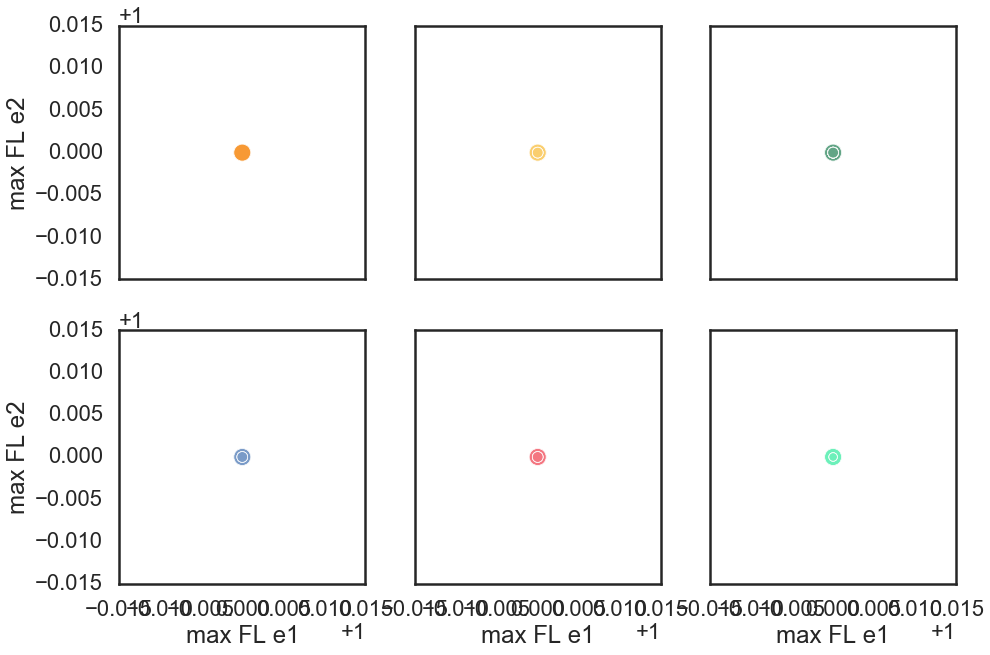

In [60]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,10))
    
for idx,i in enumerate(species):
    sns.scatterplot(data=pp, x='max FL e1', y='max FL e2', s=40, #size='num_of_species', 
                     color=other_color, 
                    ax=axs[idx//3, idx%3])
    sns.scatterplot(data=pp.loc[pp[i]], s=50, 
                x='max FL e1', y='max FL e2', size='num_of_species',  
                    #label=i,
                    color=color_dict[i]
                   , ax=axs[idx//3, idx%3],
                   legend=False
                   )

#plt.legend(loc='best')
#leg = g.get_legend()

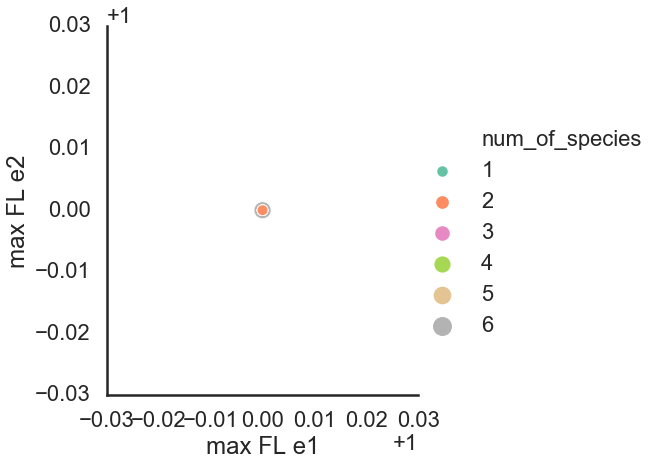

In [61]:
sns.relplot(data=pp, x='max FL e1', y='max FL e2', #s=40, 
            size='num_of_species', legend='full',
                     hue='num_of_species', palette='Set2',
           height=7)
    
#plt.legend(loc='best')
#leg = g.get_legend()

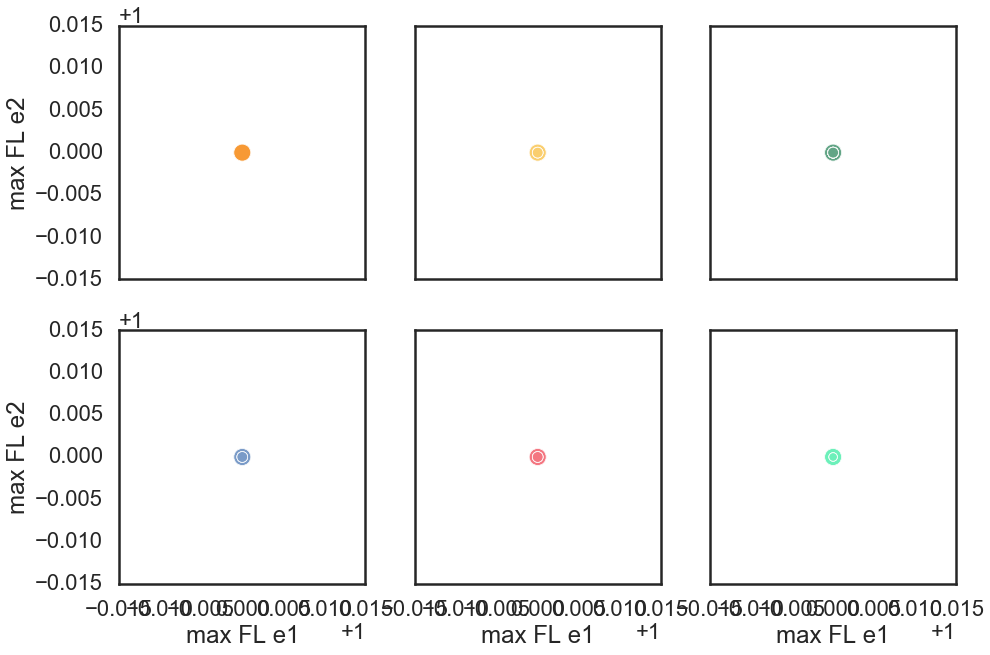

In [62]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,10))
    
for idx,i in enumerate(species):
    sns.scatterplot(data=pp.loc[pp['max FL e2']> 0.5], x='max FL e1', y='max FL e2', s=40, #size='num_of_species', 
                     color=other_color, 
                    ax=axs[idx//3, idx%3])
    sns.scatterplot(data=pp.loc[pp[i] & (pp['max FL e2']> 0.5)], s=50, 
                x='max FL e1', y='max FL e2', size='num_of_species',  
                    #label=i,
                    color=color_dict[i]
                   , ax=axs[idx//3, idx%3],
                   legend=False
                   )

#plt.legend(loc='best')
#leg = g.get_legend()

In [63]:
pp.columns

Index(['Sample', 'sample_prefix', 'MED4', 'MIT9313', 'MIT9312', 'NATL2A',
       'MIT0604', 'Syn WH8102', 'num_of_species', 'ssp', 'FL @40 days e1',
       'FL @60 days e1', 'auc e1', 'auc e2', 'max Day e1', 'max Day e2',
       'max FL e1', 'max FL e2', 'diff max FL', 'diff max Day'],
      dtype='object')

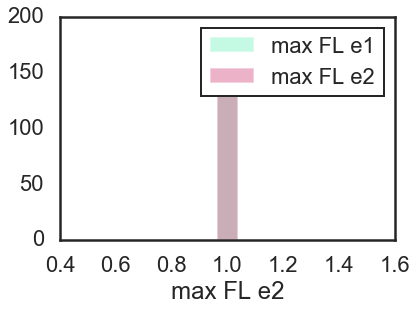

In [64]:
sns.distplot(pp['max FL e1'], label='max FL e1', kde=False, color=epallete[0])
sns.distplot(pp['max FL e2'], label='max FL e2', kde=False, color=epallete[1])
plt.legend()

In [65]:
sns.distplot(pp.loc['max Day e1'], label='max Day e1', kde=False, color=epallete[0])
sns.distplot(pp['max Day e2'], label='max Day e2', kde=False, color=epallete[1])
plt.legend()

KeyError: 'max Day e1'

In [ ]:
sns.distplot(pp.loc[pp['max Day e2']>0, 'max Day e2'], label='max Day e2', kde=False, color=epallete[1])
sns.distplot(pp.loc[pp['max Day e2']>0, 'max Day e1'], label='max Day e1', kde=False, color=epallete[0])
plt.legend()

In [ ]:
nl_df = pp.loc[pp['diff max FL']>0]
nl_df.head()
nl_df = nl_df.sort_values(by='max FL e2', axis=0, ascending=False)[['ssp', 'max FL e1', 'max FL e2']]
nl_df =pd.melt(nl_df, id_vars='ssp', value_vars=['max FL e1','max FL e2'], var_name='experiment', value_name='max FL')
sns.catplot(data=nl_df, y='ssp', hue='experiment', x='max FL', kind='bar',palette=epallete, aspect=2, height=10)


In [ ]:
nl_df = pp.loc[pp['max FL e2']<0.5]
nl_df.head()
nl_df = nl_df.sort_values(by='max FL e1', axis=0, ascending=False)[['ssp', 'max FL e1', 'max FL e2']]
nl_df =pd.melt(nl_df, id_vars='ssp', value_vars=['max FL e1','max FL e2'], var_name='experiment', value_name='max FL')
sns.catplot(data=nl_df, y='ssp', hue='experiment', x='max FL', kind='bar',palette=epallete, aspect=2, height=10)


In [ ]:
pp.columns

In [ ]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,10))
    
for idx,i in enumerate(species):
    sns.scatterplot(data=pp, x='max Day e1', y='max Day e2', s=40, #size='num_of_species', 
                     color=other_color, 
                    ax=axs[idx//3, idx%3])
    sns.scatterplot(data=pp.loc[pp[i]], s=50, 
                x='max Day e1', y='max Day e2', size='num_of_species',  
                    #label=i,
                    color=color_dict[i]
                   , ax=axs[idx//3, idx%3],
                   legend=False
                   )

#plt.legend(loc='best')
#leg = g.get_legend()

In [ ]:
sns.relplot(data=pp, x='max Day e1', y='max Day e2', #s=40, 
            size='num_of_species', legend='full',
                     hue='num_of_species', palette='Set2',
           height=7)
    
#plt.legend(loc='best')
#leg = g.get_legend()

In [ ]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,10))
    
for idx,i in enumerate(species):
    sns.scatterplot(data=pp.loc[pp['max Day e2']> 0], x='max Day e1', y='max Day e2', s=40, #size='num_of_species', 
                     color=other_color, 
                    ax=axs[idx//3, idx%3])
    sns.scatterplot(data=pp.loc[pp[i] & (pp['max FL e2']> 0.5)], s=50, 
                x='max Day e1', y='max Day e2', size='num_of_species',  
                    #label=i,
                    color=color_dict[i]
                   , ax=axs[idx//3, idx%3],
                   legend=False
                   )

#plt.legend(loc='best')
#leg = g.get_legend()

In [ ]:
pp.columns

In [ ]:
nl_df = pp.loc[pp['diff max Day']>17]
nl_df.head()
nl_df = nl_df.sort_values(by='max Day e2', axis=0, ascending=False)[['ssp', 'max Day e1', 'max Day e2']]
nl_df =pd.melt(nl_df, id_vars='ssp', value_vars=['max Day e1','max Day e2'], var_name='experiment', value_name='max Day')
sns.catplot(data=nl_df, y='ssp', hue='experiment', x='max Day', kind='bar',palette=epallete, aspect=2, height=15)


In [ ]:
nl_df = pp.loc[(pp['max Day e2']>0) & (pp['diff max Day']<=17)]
nl_df.head()
nl_df = nl_df.sort_values(by='max Day e1', axis=0, ascending=False)[['ssp', 'max Day e1', 'max Day e2']]
nl_df =pd.melt(nl_df, id_vars='ssp', value_vars=['max Day e1','max Day e2'], var_name='experiment', value_name='max Day')
sns.catplot(data=nl_df, y='ssp', hue='experiment', x='max Day', kind='bar',palette=epallete, aspect=2, height=10)


In [ ]:
pp.loc[(pp['max Day e2']>0), 'diff max Day'].min()

In [ ]:
dfg.columns

In [ ]:
ppmm = pd.melt(dfg, 
    id_vars=['Sample', 'sample_prefix', 'experiment', 'num_of_species', 'ssp', 'max FL',
       'max Day', 'FL @40 days', 'FL @60 days', 'auc', 
             #'growth rate','decline rate'
            ],
        var_name='sp', value_vars=species )
ppmm = ppmm.loc[ppmm['value']]              

In [ ]:
growing_samples = exp2_dfg.loc[exp2_dfg['max FL'] > 0.2, 'Sample']

In [ ]:
ppmm2 = ppmm.loc[ppmm['Sample'].isin(growing_samples)]

In [ ]:
pp2 = pp.loc[pp['Sample'].isin(growing_samples)]

In [ ]:
dfg2 = dfg.loc[dfg['Sample'].isin(growing_samples)]

In [ ]:
sns.catplot(data=ppmm, x='sp', y='max FL', kind='box', hue='experiment', aspect=2.2, palette=epallete)

In [ ]:
sns.catplot(data=ppmm2, x='sp', y='max FL', kind='box', hue='experiment', aspect=2.2, palette=epallete)

In [ ]:
sns.catplot(data=dfg, x='num_of_species', y='max FL', kind='box', hue='experiment', aspect=2.2, palette=epallete)

In [ ]:
sns.catplot(data=dfg2, x='num_of_species', y='max FL', kind='box', hue='experiment', aspect=2.2, palette=epallete)

In [ ]:
sns.catplot(data=dfg.loc[~dfg.Sample.isin(growing_samples)], x='num_of_species', y='max FL', kind='box', 
            hue='experiment', aspect=2.2, palette=epallete)

In [ ]:
sns.catplot(data=ppmm.loc[~ppmm.Sample.isin(growing_samples)], x='sp', y='max FL', kind='box', 
            hue='experiment', aspect=2.2, palette=epallete)

In [ ]:
sns.catplot(data=ppmm, x='sp', y='max Day', kind='box', hue='experiment', aspect=2.2, palette=epallete)

In [ ]:
sns.catplot(data=ppmm2, x='sp', y='max Day', kind='box', hue='experiment', aspect=2.2, palette=epallete)

In [ ]:
sns.catplot(data=dfg, x='num_of_species', y='max Day', kind='box', hue='experiment', aspect=2.2, palette=epallete)

In [ ]:
sns.catplot(data=dfg2, x='num_of_species', y='max Day', kind='box', hue='experiment', aspect=2.2, palette=epallete)

In [ ]:
sns.catplot(data=dfg.loc[~dfg.Sample.isin(growing_samples)], x='num_of_species', y='max Day', kind='box', 
            hue='experiment', aspect=2.2, palette=epallete)

In [ ]:
sns.catplot(data=ppmm.loc[~ppmm.Sample.isin(growing_samples)], x='sp', y='max Day', kind='box', 
            hue='experiment', aspect=2.2, palette=epallete)

In [ ]:
exp1_dfg.columns

In [ ]:
for i in ['max FL','max Day', 'FL @40 days', 'FL @60 days', 'auc', #'growth rate','decline rate'
         ]:
    sns.catplot(data=exp1_dfg, x='num_of_species', y=i, kind='box', palette='Set2',# hue='num_of_species',
                aspect=2)

In [ ]:
for i in ['max FL','max Day', 'FL @40 days', 'FL @60 days', 'auc', #'growth rate','decline rate'
         ]:
    sns.catplot(data=ppmm.loc[ppmm.experiment=='e1'], 
                x='sp', y=i, kind='box', palette=ppallete, order=species, # hue='num_of_species',
                aspect=2.2)

In [ ]:
for i in ['max FL','max Day', 'FL @40 days', 'FL @60 days', 'auc', #'growth rate','decline rate'
         ]:
    sns.catplot(data=ppmm.loc[ppmm.experiment=='e1'], 
                x='sp', y=i, kind='box', palette='Set2', 
                order=species, hue='num_of_species',
                aspect=2.2)

In [ ]:
for i in ['max FL','max Day', 'FL @40 days', 'FL @60 days', 'auc', #'growth rate','decline rate'
         ]:
    sns.catplot(data=ppmm.loc[ppmm.experiment=='e1'], 
                hue='sp', y=i, kind='box', palette=ppallete, 
                hue_order=species, x='num_of_species',
                aspect=2.2)

# experiment 2

In [ ]:
for i in ['max FL','max Day', 'auc']:
    sns.catplot(data=exp2_dfg.loc[exp2_dfg['max Day']>0], x='num_of_species', y=i, kind='box', palette='Set2',# hue='num_of_species',
                aspect=2)

In [ ]:
for i in ['max FL','max Day', 'auc',]:
    sns.catplot(data=ppmm2.loc[ppmm2.experiment=='e2'], 
                x='sp', y=i, kind='box', palette=ppallete, order=species, # hue='num_of_species',
                aspect=2.2)

In [ ]:
for i in ['max FL','max Day', 'auc',]:
    sns.catplot(data=ppmm2.loc[ppmm2.experiment=='e2'], 
                x='sp', y=i, kind='box', palette='Set2', 
                order=species, hue='num_of_species',
                aspect=2.2)

In [ ]:
for i in ['max FL','max Day',  'auc', ]:
    sns.catplot(data=ppmm2.loc[ppmm2.experiment=='e2'], 
                hue='sp', y=i, kind='box', palette=ppallete, 
                hue_order=species, x='num_of_species',
                aspect=2.2)

In [ ]:
pp.columns

In [ ]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(25,17))
    
for idx,i in enumerate(species):
    sns.scatterplot(data=pp, # .loc[pp['max FL e2']> 0.5], 
                    x='FL @60 days e1', y='FL @40 days e1', 
                    s=60, #size='num_of_species', 
                     color=other_color, 
                    ax=axs[idx//3, idx%3])
    sns.scatterplot(data=pp.loc[pp[i]], # & (pp['max FL e2']> 0.5)],
                    x='FL @60 days e1', y='FL @40 days e1', 
                    s=80, size='num_of_species',  
                    #label=i,
                    color=color_dict[i]
                   , ax=axs[idx//3, idx%3],
                   legend=False
                   )

#plt.legend(loc='best')
#leg = g.get_legend()

In [ ]:
    sns.relplot(data=pp, # .loc[pp['max FL e2']> 0.5], 
                    x='FL @60 days e1', y='FL @40 days e1', 
                    s=200, hue='num_of_species', 
                    palette='Set2', legend='full', #legend_out=True,
                    #aspect=1.6, 
                height=10, 
                   )

In [ ]:
    sns.kdeplot(pp['FL @60 days e1'], pp['FL @40 days e1'],
                    #s=200, 
                hue=pp['num_of_species'], 
                    #palette='Set2', legend='full', #legend_out=True,
                    #aspect=1.6, 
                #height=10, 
                   )

In [ ]:
ppmm.columns

In [ ]:
sns.pairplot(data=ppmm[['Sample', 'experiment',  'ssp',
       'max FL', 'max Day', 'FL @40 days', 'FL @60 days', 'auc', #'growth rate',
       #'decline rate', 
                        'sp']])

In [ ]:
sns.pairplot(data=ppmm[['Sample', 'experiment',  'ssp',
       'max FL', 'max Day', 'FL @40 days', 'FL @60 days', 'auc', #'growth rate',
       #'decline rate', 
                        'sp']],
            hue='sp', hue_order=species, palette=ppallete)

In [ ]:
ppmm.columns

In [ ]:
species

In [ ]:
from itertools import combinations
len(list(combinations(species, 5)))

In [ ]:
from itertools import combinations_with_replacement
len(list(combinations_with_replacement(['NATL2A', 'MIT0604', 'Syn WH8102'], 3)))

# PCA

In [ ]:
sample_col = 'Sample'
X = cp.experiments2X(exp1_df, value_col='relative FL', sample_col='Sample', x_col='Day', cumsummode=False)
metadf = cp.get_meta(exp1_df, meta_col=['Sample', 'sample_prefix', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species',
       'ssp'])
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col, n_components=3)

In [ ]:
fig, axs = plt.subplots(1, 3, #sharex=True, sharey=True, 
                        figsize=(25, 8))
for j,x,y  in [(0,'PCA1', 'PCA2'),
               (1,'PCA1', 'PCA3'),
               (2,'PCA2', 'PCA3'),
              ]:
    sns.scatterplot(data=dfpca, x=x, y=y, hue='num_of_species', 
            size='num_of_species', palette='Set2',
            s=100, alpha=0.9, #height=7, aspect=1.2,
            legend=False, 
                ax=axs[j]
           )

#plt.legend(bbox_to_anchor=(2,1))

In [ ]:
fig, axs = plt.subplots(6, 3, figsize=(25,35)) #, sharex=True, sharey=True)
for idx,i in enumerate(species):
#fig, axs = plt.subplots(1, 3, #sharex=True, sharey=True, 
#                        figsize=(25, 8))

    for j,x,y  in [(0,'PCA1', 'PCA2'),
                   (1,'PCA1', 'PCA3'),
                   (2,'PCA2', 'PCA3'),
                  ]:
        sns.scatterplot(data=dfpca, x=x, y=y, hue=i, 
                #size=i, #palette='Set2',
                s=100, alpha=0.9, #height=7, aspect=1.2,
                legend=False, 
                    ax=axs[idx,j],
                    palette=[other_color, color_dict[i]],                
           )

In [ ]:
fig, axs = plt.subplots(1, 3, #sharex=True, sharey=True, 
                        figsize=(25, 8))
for j,x,y  in [(0,'PCA1', 'PCA2'),
               (1,'PCA1', 'PCA3'),
               (2,'PCA2', 'PCA3'),
              ]:
    sns.scatterplot(data=dfpca, x=x, y=y, 
                s=90, alpha=0.9, #height=5, aspect=1.2,
                color=other_color, #label='other', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['NATL2A']], 
                    x=x, y=y, 
                s=110, alpha=0.9, #height=5, aspect=1.2,
                color=Natl2A_color, #label='NATL2A', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['MIT0604']], 
                    x=x, y=y, 
                s=110, alpha=0.9, #height=5, aspect=1.2,
                color=MIT0604_color, #label='MIT0604', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102']], 
                    x=x, y=y, 
                s=110, alpha=0.9, #height=5, aspect=1.2,
                color=SYN_color, #label='Syn WH8102', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['MIT0604']], 
                    x=x, y=y, 
                s=130, alpha=0.9, #height=5, aspect=1.2,
                color=syn_0606_color, #label='Syn WH8102 & MIT0604', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A']], 
                    x=x, y=y, 
                s=130, alpha=0.9, #height=5, aspect=1.2,
                color=syn_natl_color, #label='Syn WH8102 & NATL2A', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['MIT0604'] & dfpca['NATL2A']], 
                    x=x, y=y, 
                s=130, alpha=0.9, #height=5, aspect=1.2,
                color=natl_0604_color, #label='MIT0604 & NATL2A', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A'] & dfpca['MIT0604']], 
                    x=x, y=y, 
                s=150, alpha=0.9, #height=5, aspect=1.2,
                color=syn_natl_0604_color, #label='Syn WH8102 & NATL2A & MIT0604', 
                    ax=axs[j])
#plt.legend(False)
plt.legend(bbox_to_anchor=(1.6, 1))

# experiment 2 pca - growing samples

In [ ]:
sample_col = 'Sample'
X = cp.experiments2X(exp2_df, value_col='relative FL', sample_col='Sample', x_col='Day', cumsummode=False)
metadf = cp.get_meta(exp2_df, meta_col=['Sample', 'sample_prefix', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species',
       'ssp'])
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col, n_components=3)

In [ ]:
fig, axs = plt.subplots(1, 3, #sharex=True, sharey=True, 
                        figsize=(25, 8))
for j,x,y  in [(0,'PCA1', 'PCA2'),
               (1,'PCA1', 'PCA3'),
               (2,'PCA2', 'PCA3'),
              ]:
    sns.scatterplot(data=dfpca, x=x, y=y, hue='num_of_species', 
            size='num_of_species', palette='Set2',
            s=100, alpha=0.9, #height=7, aspect=1.2,
            legend=False, 
                ax=axs[j]
           )

#plt.legend(bbox_to_anchor=(2,1))

In [ ]:
fig, axs = plt.subplots(6, 3, figsize=(25,35)) #, sharex=True, sharey=True)
for idx,i in enumerate(species):
#fig, axs = plt.subplots(1, 3, #sharex=True, sharey=True, 
#                        figsize=(25, 8))

    for j,x,y  in [(0,'PCA1', 'PCA2'),
                   (1,'PCA1', 'PCA3'),
                   (2,'PCA2', 'PCA3'),
                  ]:
        sns.scatterplot(data=dfpca, x=x, y=y, hue=i, 
                #size=i, #palette='Set2',
                s=100, alpha=0.9, #height=7, aspect=1.2,
                legend=False, 
                    ax=axs[idx,j],
                    palette=[other_color, color_dict[i]],                
           )

In [ ]:
fig, axs = plt.subplots(1, 3, #sharex=True, sharey=True, 
                        figsize=(25, 8))
for j,x,y  in [(0,'PCA1', 'PCA2'),
               (1,'PCA1', 'PCA3'),
               (2,'PCA2', 'PCA3'),
              ]:
    sns.scatterplot(data=dfpca, x=x, y=y, 
                s=90, alpha=0.9, #height=5, aspect=1.2,
                color=other_color, #label='other', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['NATL2A']], 
                    x=x, y=y, 
                s=110, alpha=0.9, #height=5, aspect=1.2,
                color=Natl2A_color, #label='NATL2A', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['MIT0604']], 
                    x=x, y=y, 
                s=110, alpha=0.9, #height=5, aspect=1.2,
                color=MIT0604_color, #label='MIT0604', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102']], 
                    x=x, y=y, 
                s=110, alpha=0.9, #height=5, aspect=1.2,
                color=SYN_color, #label='Syn WH8102', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['MIT0604']], 
                    x=x, y=y, 
                s=130, alpha=0.9, #height=5, aspect=1.2,
                color=syn_0606_color, #label='Syn WH8102 & MIT0604', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A']], 
                    x=x, y=y, 
                s=130, alpha=0.9, #height=5, aspect=1.2,
                color=syn_natl_color, #label='Syn WH8102 & NATL2A', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['MIT0604'] & dfpca['NATL2A']], 
                    x=x, y=y, 
                s=130, alpha=0.9, #height=5, aspect=1.2,
                color=natl_0604_color, #label='MIT0604 & NATL2A', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A'] & dfpca['MIT0604']], 
                    x=x, y=y, 
                s=150, alpha=0.9, #height=5, aspect=1.2,
                color=syn_natl_0604_color, #label='Syn WH8102 & NATL2A & MIT0604', 
                    ax=axs[j])
#plt.legend(False)
plt.legend(bbox_to_anchor=(1.6, 1))

# experiment 2 pca

In [ ]:
sample_col = 'Sample'
X = cp.experiments2X(exp2_df.loc[exp2_df.Sample.isin(growing_samples)], 
                     value_col='relative FL', sample_col='Sample', x_col='Day', cumsummode=False)
metadf = cp.get_meta(exp2_df.loc[exp2_df.Sample.isin(growing_samples)], 
                     meta_col=['Sample', 'sample_prefix', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species',
       'ssp'])
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col, n_components=3)

In [ ]:
fig, axs = plt.subplots(1, 3, #sharex=True, sharey=True, 
                        figsize=(25, 8))
for j,x,y  in [(0,'PCA1', 'PCA2'),
               (1,'PCA1', 'PCA3'),
               (2,'PCA2', 'PCA3'),
              ]:
    sns.scatterplot(data=dfpca, x=x, y=y, hue='num_of_species', 
            size='num_of_species', palette='Set2',
            s=100, alpha=0.9, #height=7, aspect=1.2,
            legend=False, 
                ax=axs[j]
           )

#plt.legend(bbox_to_anchor=(2,1))

In [ ]:
fig, axs = plt.subplots(6, 3, figsize=(25,35)) #, sharex=True, sharey=True)
for idx,i in enumerate(species):
#fig, axs = plt.subplots(1, 3, #sharex=True, sharey=True, 
#                        figsize=(25, 8))

    for j,x,y  in [(0,'PCA1', 'PCA2'),
                   (1,'PCA1', 'PCA3'),
                   (2,'PCA2', 'PCA3'),
                  ]:
        sns.scatterplot(data=dfpca, x=x, y=y, hue=i, 
                #size=i, #palette='Set2',
                s=100, alpha=0.9, #height=7, aspect=1.2,
                legend=False, 
                    ax=axs[idx,j],
                    palette=[other_color, color_dict[i]],                
           )

In [ ]:
fig, axs = plt.subplots(1, 3, #sharex=True, sharey=True, 
                        figsize=(25, 8))
for j,x,y  in [(0,'PCA1', 'PCA2'),
               (1,'PCA1', 'PCA3'),
               (2,'PCA2', 'PCA3'),
              ]:
    sns.scatterplot(data=dfpca, x=x, y=y, 
                s=90, alpha=0.9, #height=5, aspect=1.2,
                color=other_color, #label='other', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['NATL2A']], 
                    x=x, y=y, 
                s=110, alpha=0.9, #height=5, aspect=1.2,
                color=Natl2A_color, #label='NATL2A', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['MIT0604']], 
                    x=x, y=y, 
                s=110, alpha=0.9, #height=5, aspect=1.2,
                color=MIT0604_color, #label='MIT0604', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102']], 
                    x=x, y=y, 
                s=110, alpha=0.9, #height=5, aspect=1.2,
                color=SYN_color, #label='Syn WH8102', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['MIT0604']], 
                    x=x, y=y, 
                s=130, alpha=0.9, #height=5, aspect=1.2,
                color=syn_0606_color, #label='Syn WH8102 & MIT0604', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A']], 
                    x=x, y=y, 
                s=130, alpha=0.9, #height=5, aspect=1.2,
                color=syn_natl_color, #label='Syn WH8102 & NATL2A', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['MIT0604'] & dfpca['NATL2A']], 
                    x=x, y=y, 
                s=130, alpha=0.9, #height=5, aspect=1.2,
                color=natl_0604_color, #label='MIT0604 & NATL2A', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A'] & dfpca['MIT0604']], 
                    x=x, y=y, 
                s=150, alpha=0.9, #height=5, aspect=1.2,
                color=syn_natl_0604_color, #label='Syn WH8102 & NATL2A & MIT0604', 
                    ax=axs[j])
#plt.legend(False)
plt.legend(bbox_to_anchor=(1.6, 1))

# cluster exp2

In [ ]:
sample_col = 'Sample'
X = cp.experiments2X(exp2_df, value_col='relative FL', sample_col='Sample', x_col='Day', cumsummode=False)
metadf = cp.get_meta(exp2_df, meta_col=['Sample', 'sample_prefix', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species',
       'ssp'])
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='num_of_species', 
            #size='num_of_species', 
            palette='Set2',
            s=50, alpha=0.9, height=7, aspect=1.2,
            legend='full'
           )

In [ ]:
dfpca.columns

In [ ]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
for idx,i in enumerate(species):
    sns.scatterplot(data=dfpca, x='SNE1', y='SNE2', hue=i, 
            #size='num_of_species',
            s=50, alpha=0.9, #height=5, aspect=1.2,
            legend=None, 
                    palette=[other_color, color_dict[i]],
                ax=axs[idx//3, idx%3],
                
           )

In [ ]:
sns.scatterplot(data=dfpca, x='SNE1', y='SNE2', 
            s=90, alpha=0.9, #height=5, aspect=1.2,
            color=other_color, label='other')
sns.scatterplot(data=dfpca[dfpca['NATL2A']], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=Natl2A_color, label='NATL2A')
sns.scatterplot(data=dfpca[dfpca['MIT0604']], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=MIT0604_color, label='MIT0604')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102']], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=SYN_color, label='Syn WH8102')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['MIT0604']], 
                x='SNE1', y='SNE2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=syn_0606_color, label='Syn WH8102 & MIT0604')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A']], 
                x='SNE1', y='SNE2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=syn_natl_color, label='Syn WH8102 & NATL2A')
sns.scatterplot(data=dfpca[dfpca['MIT0604'] & dfpca['NATL2A']], 
                x='SNE1', y='SNE2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=natl_0604_color, label='MIT0604 & NATL2A')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A'] & dfpca['MIT0604']], 
                x='SNE1', y='SNE2', 
            s=150, alpha=0.9, #height=5, aspect=1.2,
            color=syn_natl_0604_color, label='Syn WH8102 & NATL2A & MIT0604')

plt.legend(bbox_to_anchor=(1.6, 1))

In [ ]:

sns.scatterplot(data=dfpca[dfpca.Sample.isin(growing_samples)], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color='orange', label='growing')
sns.scatterplot(data=dfpca[~dfpca.Sample.isin(growing_samples)], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color='purple', label='not growing')


In [ ]:
sample_col = 'Sample'
X = cp.experiments2X(exp2_df.loc[exp2_df.Sample.isin(growing_samples)], 
                     value_col='relative FL', sample_col='Sample', x_col='Day', cumsummode=False)
metadf = cp.get_meta(exp2_df.loc[exp2_df.Sample.isin(growing_samples)], 
                     meta_col=['Sample', 'sample_prefix', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species',
       'ssp'])
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)#, perplexity=50)

In [ ]:
X.shape

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='num_of_species', 
            #size='num_of_species', 
            palette='Set2',
            s=50, alpha=0.9, height=7, aspect=1.2,
            legend='full'
           )

In [ ]:
dfpca.columns

In [ ]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
for idx,i in enumerate(species):
    sns.scatterplot(data=dfpca, x='SNE1', y='SNE2', hue=i, 
            #size='num_of_species',
            s=50, alpha=0.9, #height=5, aspect=1.2,
            legend=None, 
                    palette=[other_color, color_dict[i]],
                ax=axs[idx//3, idx%3],
                
           )

In [ ]:
sns.scatterplot(data=dfpca, x='SNE1', y='SNE2', 
            s=90, alpha=0.9, #height=5, aspect=1.2,
            color=other_color, label='other')
sns.scatterplot(data=dfpca[dfpca['NATL2A']], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=Natl2A_color, label='NATL2A')
sns.scatterplot(data=dfpca[dfpca['MIT0604']], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=MIT0604_color, label='MIT0604')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102']], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=SYN_color, label='Syn WH8102')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['MIT0604']], 
                x='SNE1', y='SNE2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=syn_0606_color, label='Syn WH8102 & MIT0604')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A']], 
                x='SNE1', y='SNE2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=syn_natl_color, label='Syn WH8102 & NATL2A')
sns.scatterplot(data=dfpca[dfpca['MIT0604'] & dfpca['NATL2A']], 
                x='SNE1', y='SNE2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=natl_0604_color, label='MIT0604 & NATL2A')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A'] & dfpca['MIT0604']], 
                x='SNE1', y='SNE2', 
            s=150, alpha=0.9, #height=5, aspect=1.2,
            color=syn_natl_0604_color, label='Syn WH8102 & NATL2A & MIT0604')

plt.legend(bbox_to_anchor=(1.6, 1))

In [ ]:

sns.scatterplot(data=dfpca[dfpca.Sample.isin(growing_samples)], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color='orange', label='growing')
sns.scatterplot(data=dfpca[~dfpca.Sample.isin(growing_samples)], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color='purple', label='not growing')


# cluster exp1

In [ ]:
sample_col = 'Sample'
X = cp.experiments2X(exp1_df, value_col='relative FL', sample_col='Sample', x_col='Day', cumsummode=False)
metadf = cp.get_meta(exp1_df, meta_col=['Sample', 'sample_prefix', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species',
       'ssp'])
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='num_of_species', 
            #size='num_of_species', 
            palette='Set2',
            s=50, alpha=0.9, height=7, aspect=1.2,
            legend='full'
           )

In [ ]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
for idx,i in enumerate(species):
    sns.scatterplot(data=dfpca, x='SNE1', y='SNE2', hue=i, 
            #size='num_of_species',
            s=50, alpha=0.9, #height=5, aspect=1.2,
            legend=None, 
                    palette=[other_color, color_dict[i]],
                ax=axs[idx//3, idx%3],
                
           )

In [ ]:
dfpca.columns


In [ ]:
sns.scatterplot(data=dfpca, x='SNE1', y='SNE2', 
            s=90, alpha=0.9, #height=5, aspect=1.2,
            color=other_color, label='other')
sns.scatterplot(data=dfpca[dfpca['NATL2A']], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=Natl2A_color, label='NATL2A')
sns.scatterplot(data=dfpca[dfpca['MIT0604']], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=MIT0604_color, label='MIT0604')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102']], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=SYN_color, label='Syn WH8102')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['MIT0604']], 
                x='SNE1', y='SNE2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=syn_0606_color, label='Syn WH8102 & MIT0604')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A']], 
                x='SNE1', y='SNE2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=syn_natl_color, label='Syn WH8102 & NATL2A')
sns.scatterplot(data=dfpca[dfpca['MIT0604'] & dfpca['NATL2A']], 
                x='SNE1', y='SNE2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=natl_0604_color, label='MIT0604 & NATL2A')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A'] & dfpca['MIT0604']], 
                x='SNE1', y='SNE2', 
            s=150, alpha=0.9, #height=5, aspect=1.2,
            color=syn_natl_0604_color, label='Syn WH8102 & NATL2A & MIT0604')

plt.legend(bbox_to_anchor=(1.6, 1))

In [ ]:
dfpca.columns

# cluster exp2

In [ ]:
sample_col = 'Sample'
X = cp.experiments2X(exp2_df, value_col='relative FL', sample_col='Sample', x_col='Day', cumsummode=False)
metadf = cp.get_meta(exp2_df, meta_col=['Sample', 'sample_prefix', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species',
       'ssp'])
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='num_of_species', 
            #size='num_of_species', 
            palette='Set2',
            s=50, alpha=0.9, height=7, aspect=1.2,
            legend='full'
           )

In [ ]:
dfpca.columns

In [ ]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
for idx,i in enumerate(species):
    sns.scatterplot(data=dfpca, x='PCA1', y='PCA2', hue=i, 
            #size='num_of_species',
            s=50, alpha=0.9, #height=5, aspect=1.2,
            legend=None, 
                    palette=[other_color, color_dict[i]],
                ax=axs[idx//3, idx%3],
                
           )

In [ ]:
sns.scatterplot(data=dfpca, x='PCA1', y='PCA2', 
            s=90, alpha=0.9, #height=5, aspect=1.2,
            color=other_color, label='other')
sns.scatterplot(data=dfpca[dfpca['NATL2A']], 
                x='PCA1', y='PCA2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=Natl2A_color, label='NATL2A')
sns.scatterplot(data=dfpca[dfpca['MIT0604']], 
                x='PCA1', y='PCA2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=MIT0604_color, label='MIT0604')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102']], 
                x='PCA1', y='PCA2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=SYN_color, label='Syn WH8102')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['MIT0604']], 
                x='PCA1', y='PCA2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=syn_0606_color, label='Syn WH8102 & MIT0604')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A']], 
                x='PCA1', y='PCA2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=syn_natl_color, label='Syn WH8102 & NATL2A')
sns.scatterplot(data=dfpca[dfpca['MIT0604'] & dfpca['NATL2A']], 
                x='PCA1', y='PCA2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=natl_0604_color, label='MIT0604 & NATL2A')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A'] & dfpca['MIT0604']], 
                x='PCA1', y='PCA2', 
            s=150, alpha=0.9, #height=5, aspect=1.2,
            color=syn_natl_0604_color, label='Syn WH8102 & NATL2A & MIT0604')

plt.legend(bbox_to_anchor=(1.6, 1))

In [ ]:

sns.scatterplot(data=dfpca[dfpca.Sample.isin(growing_samples)], 
                x='PCA1', y='PCA2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color='orange', label='growing')
sns.scatterplot(data=dfpca[~dfpca.Sample.isin(growing_samples)], 
                x='PCA1', y='PCA2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color='purple', label='not growing')


In [ ]:
sample_col = 'Sample'
X = cp.experiments2X(exp2_df.loc[exp2_df.Sample.isin(growing_samples)], 
                     value_col='relative FL', sample_col='Sample', x_col='Day', cumsummode=False)
metadf = cp.get_meta(exp2_df.loc[exp2_df.Sample.isin(growing_samples)], 
                     meta_col=['Sample', 'sample_prefix', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species',
       'ssp'])
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)#, perplexity=50)

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='num_of_species', 
            #size='num_of_species', 
            palette='Set2',
            s=50, alpha=0.9, height=7, aspect=1.2,
            legend='full'
           )

In [ ]:
dfpca.columns

In [ ]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
for idx,i in enumerate(species):
    sns.scatterplot(data=dfpca, x='PCA1', y='PCA2', hue=i, 
            #size='num_of_species',
            s=50, alpha=0.9, #height=5, aspect=1.2,
            legend=None, 
                    palette=[other_color, color_dict[i]],
                ax=axs[idx//3, idx%3],
                
           )

In [ ]:
sns.scatterplot(data=dfpca, x='PCA1', y='PCA2', 
            s=90, alpha=0.9, #height=5, aspect=1.2,
            color=other_color, label='other')
sns.scatterplot(data=dfpca[dfpca['NATL2A']], 
                x='PCA1', y='PCA2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=Natl2A_color, label='NATL2A')
sns.scatterplot(data=dfpca[dfpca['MIT0604']], 
                x='PCA1', y='PCA2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=MIT0604_color, label='MIT0604')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102']], 
                x='PCA1', y='PCA2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=SYN_color, label='Syn WH8102')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['MIT0604']], 
                x='PCA1', y='PCA2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=syn_0606_color, label='Syn WH8102 & MIT0604')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A']], 
                x='PCA1', y='PCA2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=syn_natl_color, label='Syn WH8102 & NATL2A')
sns.scatterplot(data=dfpca[dfpca['MIT0604'] & dfpca['NATL2A']], 
                x='PCA1', y='PCA2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=natl_0604_color, label='MIT0604 & NATL2A')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A'] & dfpca['MIT0604']], 
                x='PCA1', y='PCA2', 
            s=150, alpha=0.9, #height=5, aspect=1.2,
            color=syn_natl_0604_color, label='Syn WH8102 & NATL2A & MIT0604')

plt.legend(bbox_to_anchor=(1.6, 1))

In [ ]:

sns.scatterplot(data=dfpca[dfpca.Sample.isin(growing_samples)], 
                x='PCA1', y='PCA2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color='orange', label='growing')
sns.scatterplot(data=dfpca[~dfpca.Sample.isin(growing_samples)], 
                x='PCA1', y='PCA2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color='purple', label='not growing')


# cluster exp1

In [ ]:
sample_col = 'Sample'
X = cp.experiments2X(exp1_df, value_col='relative FL', sample_col='Sample', x_col='Day', cumsummode=False)
metadf = cp.get_meta(exp1_df, meta_col=['Sample', 'sample_prefix', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species',
       'ssp'])
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='num_of_species', 
            #size='num_of_species', 
            palette='Set2',
            s=50, alpha=0.9, height=7, aspect=1.2,
            legend='full'
           )

In [ ]:
dfpca.columns

In [ ]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
for idx,i in enumerate(species):
    sns.scatterplot(data=dfpca, x='PCA1', y='PCA2', hue=i, 
            #size='num_of_species',
            s=50, alpha=0.9, #height=5, aspect=1.2,
            legend=None, 
                    palette=[other_color, color_dict[i]],
                ax=axs[idx//3, idx%3],
                
           )

In [ ]:
sns.scatterplot(data=dfpca, x='PCA1', y='PCA2', 
            s=90, alpha=0.9, #height=5, aspect=1.2,
            color=other_color, label='other')
sns.scatterplot(data=dfpca[dfpca['NATL2A']], 
                x='PCA1', y='PCA2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=Natl2A_color, label='NATL2A')
sns.scatterplot(data=dfpca[dfpca['MIT0604']], 
                x='PCA1', y='PCA2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=MIT0604_color, label='MIT0604')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102']], 
                x='PCA1', y='PCA2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=SYN_color, label='Syn WH8102')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['MIT0604']], 
                x='PCA1', y='PCA2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=syn_0606_color, label='Syn WH8102 & MIT0604')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A']], 
                x='PCA1', y='PCA2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=syn_natl_color, label='Syn WH8102 & NATL2A')
sns.scatterplot(data=dfpca[dfpca['MIT0604'] & dfpca['NATL2A']], 
                x='PCA1', y='PCA2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=natl_0604_color, label='MIT0604 & NATL2A')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A'] & dfpca['MIT0604']], 
                x='PCA1', y='PCA2', 
            s=150, alpha=0.9, #height=5, aspect=1.2,
            color=syn_natl_0604_color, label='Syn WH8102 & NATL2A & MIT0604')

plt.legend(bbox_to_anchor=(1.6, 1))

In [ ]:

sns.scatterplot(data=dfpca[dfpca.Sample.isin(growing_samples)], 
                x='PCA1', y='PCA2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color='orange', label='growing')
sns.scatterplot(data=dfpca[~dfpca.Sample.isin(growing_samples)], 
                x='PCA1', y='PCA2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color='purple', label='not growing')
